In [3]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import os
import fnmatch
from torch.utils.data import Dataset
from PIL import Image
from patch_functions import *
from loss_functions import *
from dataset_functions import *
import torch.optim as optim
import shutil
import scipy 


### Usefull trasformation functions

In [6]:
# Transforming from PIL to Tensor
transform1 = transforms.ToTensor()

# Transforming from Tensor to PIL
transform2 = transforms.ToPILImage()

### Definition of the model

In [4]:
%%capture
# Model: con queste due righe di codice è possibile definire il modello 
model = torch.hub.load('ultralytics/yolov3', 'yolov3', autoshape = False)  # or yolov3-spp, yolov3-tiny, custom
model.eval()

In [5]:
%%capture
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#### Labels for the training

In [10]:
%%capture
# Define the model without the autoshape = False 
model_lab = torch.hub.load('ultralytics/yolov3', 'yolov3')  # or yolov3-spp, yolov3-tiny, custom
model_lab.to(device)

In [7]:
images_path = '/home/andread98/yolov3/inria/INRIAPerson/Train/pos'
images = [f for f in os.listdir(images_path) if f.endswith('.png')]

for image in images:
    # I consider the txt file path 
    img_path = images_path + '/' + image
    # Get the results 
    results = model_lab(img_path)
    # Trasform the yolo labels into a numpy array to save them
    array = results.xywhn[0].cpu().numpy()
    # Select only the object that are people
    array = array[array[:,-1] == 0]
    # Classes in the first column 
    permutation = [1, 2, 3, 4, 5, 0]
    idx = np.empty_like(permutation)
    idx[permutation] = np.arange(len(permutation))
    array[:] = array[:, idx]
    # Remove the last column
    array = array[:,:-1]
    # Save the array 
    np.savetxt(images_path + '/yolo-labels/' + image[0:-4] + '.txt', array)

In [1]:
# Number of images in the training set

list = os.listdir('/home/andread98/yolov3/inria/INRIAPerson/Train/pos')
print(len(list)-1)

# Number of images in the training set

list = os.listdir('/home/andread98/yolov3/inria/INRIAPerson/Train/pos/yolo-labels')
print(len(list))

# The two quantities of elements match

614
614


### Isolate all the image with a most 2 people

In [17]:
images_path = '/home/andread98/yolov3/inria/INRIAPerson/Train/pos'
images = [f for f in os.listdir(images_path) if f.endswith('.png')]

for image in images:
    # I consider the txt file path 
    img_path = images_path + '/' + image
    destination = '/home/andread98/yolov3/dataset/' + image
    # Get the results 
    results = model_lab(img_path)
    # Trasform the yolo labels into a numpy array to save them
    array = results.xywhn[0].cpu().numpy()
    # Select only the object that are people
    array = array[array[:,-1] == 0]
    # Classes in the first column 
    permutation = [1, 2, 3, 4, 5, 0]
    idx = np.empty_like(permutation)
    idx[permutation] = np.arange(len(permutation))
    array[:] = array[:, idx]
    # Remove the last column
    array = array[:,:-1]
    if array.shape[0] <= 2:
        # Save the array 
        np.savetxt('/home/andread98/yolov3/dataset/yolo-labels/' + image[0:-4] + '.txt', array)
        # Save a copy of the image in the right folder
        shutil.copy(img_path, destination)
    

In [18]:
# Number of images in the training set

list = os.listdir('/home/andread98/yolov3/dataset')
print(len(list)-1)

# Number of images in the training set

list = os.listdir('/home/andread98/yolov3/dataset/yolo-labels')
print(len(list))

# The two quantities of elements match

133
133


### Changing the name to the masks

In [12]:
masks_path = '/home/andread98/yolov3/data_mask/mask'
masks = [f for f in os.listdir(masks_path) if f.endswith('.mat')]


In [21]:
for mask in masks:
    origin = '/home/andread98/yolov3/data_mask/mask/' + mask
    destination ='/home/andread98/yolov3/data_mask/masks/image' + str(mask[6:-4]) +'.mat'
    shutil.copy(origin, destination)

### Save the tensor instead of the .mat file 

In [9]:
masks_path = '/home/andread98/yolov3/data_mask/masks'
masks = [f for f in os.listdir(masks_path) if f.endswith('.mat')]

for mask in masks:
    number = mask[5:-4]
    matfile = scipy.io.loadmat('/home/andread98/yolov3/data_mask/masks/image' + number + '.mat')
    # Extract the mask from it 
    mask = matfile['BW'+ number]
    tensor = torch.from_numpy(mask)
    save_directory = '/home/andread98/yolov3/data_mask/mask/image'  + number + '.pt'
    torch.save(tensor, save_directory)


### Difference between model() and model().eval()

In [ ]:
# Define the device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# create the image
image = torch.rand((1,3,640,640))
image = image.to(device)

# model without eval
model = torch.hub.load('ultralytics/yolov3', 'yolov3', autoshape = False)  # or yolov3-spp, yolov3-tiny, custom

output = model(image)
print(output)

# model with eval
model = model.eval()
output = model(image)
print(output)

#They are different, I should use the eval. We don't want to train the network
#But the parameters of the patch!

### VOC dataset

In [70]:
# Importing the dataset and convert the images to tensors 

training_data = datasets.VOCDetection(
    root= "data",
    year = "2007",
    download = False,
    transform = ToTensor()
)


In [71]:
batch_size = 1

train_loader = torch.utils.data.DataLoader(
                training_data,
                batch_size=batch_size,
                shuffle=True,
                num_workers=8)

### What is the output of the network?

In [16]:
img_dir = "/home/andread98/yolov3/inria/INRIAPerson/Train/pos"
batch_size = 6
img_size=640

# Create the train_loader that will be used for the training routine 
# Setting the batch and the image directory

train_loader_2 = torch.utils.data.DataLoader(
                InriaDataset(img_dir, img_size, shuffle=True),
                batch_size=batch_size,
                shuffle=True)

In [6]:
for i, data in enumerate(train_loader_2):
    image = data
    break

In [7]:
%%capture
model = torch.hub.load('ultralytics/yolov3', 'yolov3', autoshape = False)  # or yolov3-spp, yolov3-tiny, custom
model.cuda()

In [8]:
for i, data in enumerate(train_loader_2):
    image = data.cuda()
    print(image.dtype)
    outputs = model(image)
    print('Len output: ',len(outputs))
    print(outputs[0].shape)
    print(outputs[1][0].shape)
    print(outputs[1][1].shape)
    print(outputs[1][2].shape)
    if i==0:
        break

torch.float32
Len output:  2
torch.Size([6, 25200, 85])
torch.Size([6, 3, 80, 80, 85])
torch.Size([6, 3, 40, 40, 85])
torch.Size([6, 3, 20, 20, 85])


### How to obtain the first tensor given the others
Note that the coordinates of the BB still don't make sense, I need to understand how to compute them starting form the other outputs. 
But, to define the loss the BB coordinates are not necessary. The BB coordinated can be found with the basic version of the algorithm.

In [45]:
# %%capture
final_true = outputs[0]
yolo_output1 = outputs[1][0]
print(torch.reshape(yolo_output1, (1,3*80*80,85))[0,0,:])
yolo_output1 = torch.reshape(yolo_output1, (1,3*80*80,85)).sigmoid()
print(yolo_output1)

yolo_output2 = outputs[1][1]
yolo_output2 = torch.reshape(yolo_output2, (1,3*40*40,85)).sigmoid()

yolo_output3 = outputs[1][2]
yolo_output3 = torch.reshape(yolo_output3, (1,3*20*20,85)).sigmoid()

final_tensor = torch.cat((yolo_output1,yolo_output2,yolo_output3), dim=1)
print(final_true.shape)
final_tensor.shape[0]

tensor([  0.97231,   0.12388,   0.34327,  -0.38789, -12.25723,  -3.23859,  -6.97841,  -5.25728,  -6.79948,  -7.15996,  -7.24253,  -7.53783,  -6.73830,  -6.37754,  -4.50419,  -6.37800,  -5.50886,  -6.77535,  -6.73173,  -4.28813,  -6.93197,  -6.84087,  -6.78025,  -6.29227,  -6.62484,  -6.94971,  -7.39728,  -7.66485,
         -7.53894,  -6.14535,  -4.71841,  -5.66537,  -6.83824,  -6.80403,  -5.81056,  -7.16004,  -6.90741,  -1.94358,  -4.48559,  -7.29603,  -7.08646,  -7.36169,  -6.55336,  -7.25745,  -3.94874,  -5.58981,  -3.89496,  -6.64983,  -6.33828,  -5.52751,  -4.41237,  -4.70032,  -1.01072,  -6.77318,  -1.89668,  -6.13228,
         -4.53293,  -6.20302,  -7.05708,  -5.08217,  -5.53444,  -4.86435,  -7.01460,  -4.04729,  -7.55544,  -6.47353,  -6.95861,  -6.41884,  -7.12364,  -5.74580,  -6.27983,  -7.47586,  -6.33861,  -7.21214,  -7.40816,  -7.57872,  -6.61201,  -6.94611,  -5.58567,  -5.87415,  -4.15872,  -6.38599,  -5.03909,  -7.15184,
         -6.08031], device='cuda:0')
tensor([[[7.255

1

In [25]:
%%capture
print(final_true[0,0,:])
print(final_tensor[0,0,:])
print(torch.reshape(yolo_output1, (1,3*80*80,85)))
# Same probabilities!!
print(final_true[0,0,4:]==final_tensor[0,0,4:])
print(final_true[0,22999,4:]==final_tensor[0,22999,4:])
print(final_true[0,25199,4:]==final_tensor[0,25199,4:])

In [75]:
#This works, so we can use the other tensors to compute the backward step
torch.sum(final_tensor).backward()

### Training Routine

#### Entire image

Iteration number:  0
Max image grad:  tensor(0.04042, device='cuda:0')
Min image grad:  tensor(-0.05354, device='cuda:0')
Max image:  tensor(0.50161, device='cuda:0', grad_fn=<MaxBackward1>)
Min image:  tensor(0.49879, device='cuda:0', grad_fn=<MinBackward1>)
Loss value:  tensor(4.98516, device='cuda:0', grad_fn=<MeanBackward0>)
Iteration number:  1
Max image grad:  tensor(0.11285, device='cuda:0')
Min image grad:  tensor(-0.09770, device='cuda:0')
Max image:  tensor(0.50454, device='cuda:0', grad_fn=<MaxBackward1>)
Min image:  tensor(0.49576, device='cuda:0', grad_fn=<MinBackward1>)
Loss value:  tensor(4.95706, device='cuda:0', grad_fn=<MeanBackward0>)
Iteration number:  2
Max image grad:  tensor(0.06064, device='cuda:0')
Min image grad:  tensor(-0.07849, device='cuda:0')
Max image:  tensor(0.50391, device='cuda:0', grad_fn=<MaxBackward1>)
Min image:  tensor(0.49617, device='cuda:0', grad_fn=<MinBackward1>)
Loss value:  tensor(5.81877, device='cuda:0', grad_fn=<MeanBackward0>)
Iterati

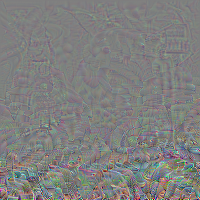

In [43]:
for i in range(5):   
    # Patch definition
    patch = torch.full((1, 3, 100, 100), 0.5)
    patch = patch.to(device)
    patch.requires_grad_(True)

    # Black image definition
    black_image = torch.zeros((1,3,640,640))
    black_image = black_image.to(device)

    # Loss function
    loss_function = new_loss_tprob(i).to(device)

    # Patch applier function
    apply_function = apply_patch().to(device)

    # Optimizer definition
    optimizer = optim.SGD([patch], lr = 0.03)

    # torch.autograd.set_detect_anomaly(True)

    for epoch in range(50000):  # loop over the dataset multiple times
        print('Iteration number: ', epoch)
        
        b_image = black_image.detach().clone()

        # Applying the patch to the black-image
        image = apply_function(patch,b_image)
        
        # forward of the model
        outputs = model(image)
        loss = torch.mean(-loss_function(outputs))
        # print(loss)

        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('Max image grad: ',torch.max(patch.grad))
        print('Min image grad: ',torch.min(patch.grad))
        patch.data.clamp_(0, 1)
        print('Max image: ',torch.max(patch))
        print('Min image: ',torch.min(patch))        # Keep the patch in range (0,1)
        print('Loss value: ',loss)
    
    name = '/home/andread98/yolov3/Results/SGD_class' + str(i) + '.pt'
    torch.save(patch, name)

    # image_PIL = transform2(patch.squeeze(0))
    # image_PIL

In [ ]:
# Save and Load the patch

# torch.save(tensor_name, 'tensor_name.pt')
# tensor_name = torch.load('tensor_name.pt')

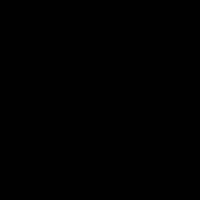

In [13]:
tensor = torch.zeros((3,200,200))
tensor_PIL = transform2(tensor)
tensor_PIL

### Testing the crafted Patch
Let's see if the patch works

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
%%capture
model_test = torch.hub.load('ultralytics/yolov3', 'yolov3')  # or yolov3-spp, yolov3-tiny, custom
model_test.eval()

In [45]:
patch = torch.load('patch.pt')
black = torch.zeros((1,3,640,640))
apply_function = apply_patch()
image = apply_function(patch,black)
image_PIL = transform2(image.squeeze(0))

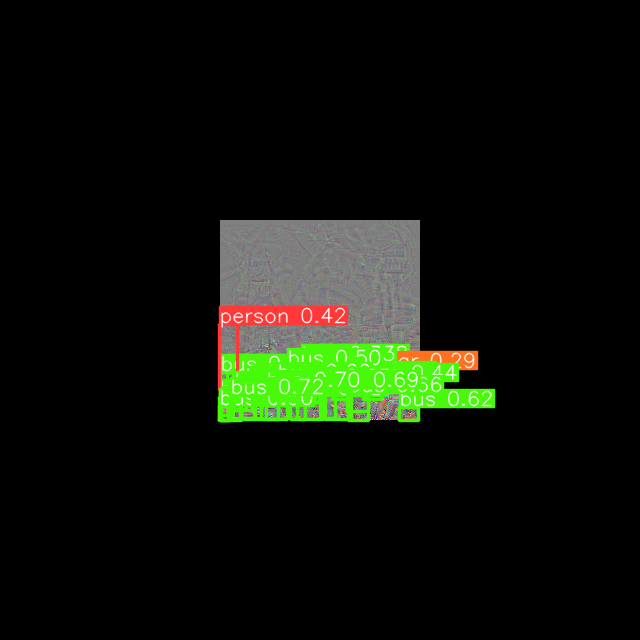

tensor([[0.37930, 0.63711, 0.03945, 0.03750, 0.71680, 5.00000],
        [0.43242, 0.63086, 0.03203, 0.04766, 0.70166, 5.00000],
        [0.52852, 0.63164, 0.04141, 0.04844, 0.68652, 5.00000],
        [0.56055, 0.63633, 0.03125, 0.04219, 0.66260, 5.00000],
        [0.48516, 0.62891, 0.04062, 0.05234, 0.65088, 5.00000],
        [0.63828, 0.64648, 0.02969, 0.02109, 0.62207, 5.00000],
        [0.44531, 0.60938, 0.02422, 0.02969, 0.60107, 5.00000],
        [0.38047, 0.62422, 0.02812, 0.03281, 0.54443, 5.00000],
        [0.41641, 0.63242, 0.03672, 0.04688, 0.53174, 5.00000],
        [0.34961, 0.64648, 0.01328, 0.02187, 0.50488, 5.00000],
        [0.45937, 0.59609, 0.02187, 0.04766, 0.50439, 5.00000],
        [0.36133, 0.64453, 0.03047, 0.02500, 0.46509, 5.00000],
        [0.39443, 0.61406, 0.02129, 0.02812, 0.45630, 5.00000],
        [0.58164, 0.61016, 0.02891, 0.02734, 0.43677, 5.00000],
        [0.35684, 0.55742, 0.02773, 0.10078, 0.42480, 0.00000],
        [0.54453, 0.60273, 0.02344, 0.01

In [46]:
outputs = model_test(image_PIL)
outputs.show()
print(outputs.xywhn[0])

### Trying to apply the patch on all the people

In [5]:
import torch
from dataset_functions import *
from patch_functions import *

In [6]:
images_path = '/home/andread98/yolov3/inria/INRIAPerson/Train/pos'
labels_path = '/home/andread98/yolov3/inria/INRIAPerson/Train/pos/yolo-labels'
max_lab = 20
img_size = 614
batch_size = 6



train_loader = torch.utils.data.DataLoader(
                InriaDataset(images_path, labels_path, max_lab, img_size,
                             shuffle=True),
                batch_size=batch_size,
                shuffle=True,
                num_workers=10)

In [ ]:
%%capture
# Definizione dei parametri
a = torch.tensor(0.70)
a.requires_grad_(True)
b = torch.tensor(0.3)
b.requires_grad_(True)
color1 = torch.tensor([1.0,0.0,0.0])
color1.requires_grad_(True)
color2 = torch.tensor([0.0,0.0,1.0])
color2.requires_grad_(True)

params = [a, color1, color2]

gen_function = Fractal_Patch_Generator(20, 300, 3,Tile_Creator_Square,Mask_Creator,2)

gen_function.populate(params)
adv_patch = gen_function.application()
adv_patch.to(device)

In [8]:
adv_patch.shape

torch.Size([3, 300, 300])

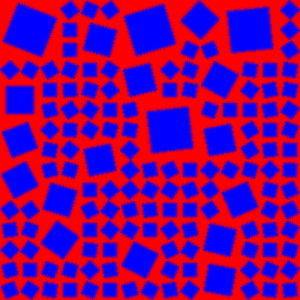

In [9]:
image_PIL = transform2(adv_patch)
image_PIL

In [ ]:
patch_applier = PatchApplier().to(device)
patch_transformer = PatchTransformer().to(device)
img_size = 614

for i_batch, (img_batch, lab_batch) in enumerate(train_loader):
    print(img_batch.shape)
    img_batch = img_batch.to(device)
    lab_batch = lab_batch.to(device)
    adv_patch = adv_patch.to(device)
    # print(lab_batch)
    adv_batch_t = patch_transformer(adv_patch, lab_batch, img_size, do_rotate=True, rand_loc=False)
    p_img_batch = patch_applier(img_batch, adv_batch_t)
    p_img_batch = F.interpolate(p_img_batch, (img_size, img_size))
                            
    if i_batch == 0:
        break

In [11]:
adv_batch_t.shape

torch.Size([6, 20, 3, 614, 614])

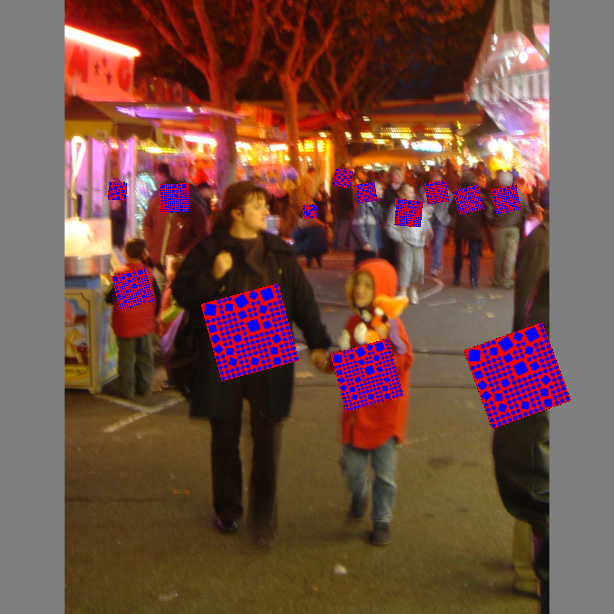

In [13]:
image = p_img_batch[1,:,:,:]

image_PIL = transform2(image)
image_PIL

### Working of the mask, how to create a dataloader with image and mask

In [6]:
from dataset_functions import *

img_dir = '/home/andread98/yolov3/MyWork/data_mask'
mask_dir = '/home/andread98/yolov3/MyWork/data_mask/mask'
img_size = 640


train_loader = torch.utils.data.DataLoader(
                VOCmask(img_dir, mask_dir, img_size,
                             shuffle=True),
                batch_size=2,
                shuffle=True,
                num_workers=10)

dataset = VOCmask(img_dir, mask_dir, img_size,
                             shuffle=True)

In [7]:
for i_batch, (img_batch, mask_batch) in enumerate(train_loader):
    images = img_batch
    print(images.shape)
    masks = mask_batch
    print(masks.shape)

    if True:
        break

torch.Size([2, 3, 640, 640])
torch.Size([2, 3, 640, 640])


In [8]:
model = torch.hub.load('ultralytics/yolov3', 'yolov3', autoshape = False)  # or yolov3-spp, yolov3-tiny, custom
model.eval()

Using cache found in /home/andread98/.cache/torch/hub/ultralytics_yolov3_master


Model(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
    (3): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (4): Sequential(
      (0): Bottleneck(
        (cv1): Conv(
          (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padd

In [9]:
images = images.to(device)
masks = masks.to(device)
results = model(images)

In [10]:
patch = torch.rand((3,640,640)).to(device)

In [11]:
attacked_images = images*(1-masks) + patch*masks

In [12]:
attacked_images.shape

torch.Size([2, 3, 640, 640])

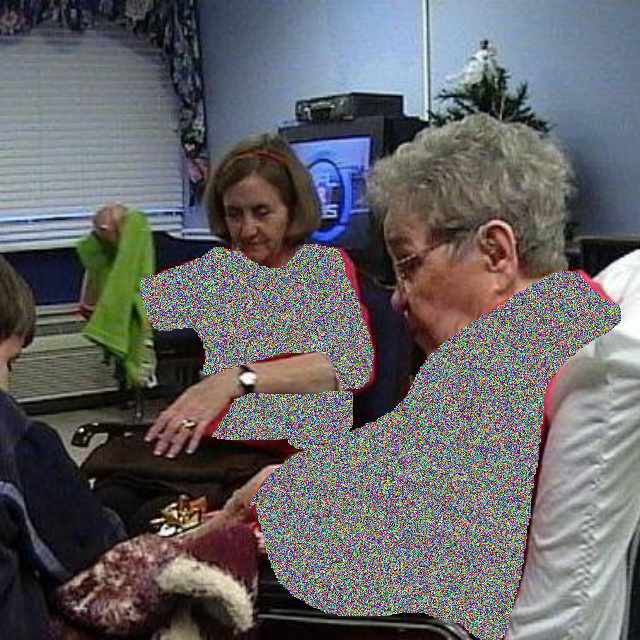

In [13]:
att_image = attacked_images[0].squeeze(0)
att_image_PIL = transform2(att_image)
att_image_PIL

### Ghost Patches

In [19]:
import torch
import random
import numpy as np
import torchvision.transforms.functional as TF
import math
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from median_pool import MedianPool2d
import math

In [26]:
class Tile_Creator_Square(object):

    def __init__(self):
        pass
    
    def __call__(self, dim, params):
        # Tensore delle distanze 
        image = torch.zeros((3,dim,dim))
        for i in range(dim):
            for j in range(dim):
                image[:,i,j] = torch.max(torch.abs(torch.tensor(i-(dim-1)/2)/params[0]),torch.abs(torch.tensor(j-(dim-1)/2))/params[0]) - dim/2
        coeff = image.sigmoid()

        # Creation of the colors tensors
        color1_image = params[1].unsqueeze(-1).unsqueeze(-1)
        color1_image = color1_image.expand(-1, dim, dim)

        return (1-coeff)*color1_image, (1-coeff)

    def Params_Creator(self):
        a = torch.tensor(0.50)
        a.requires_grad_(True)
        color1 = torch.tensor([0,1.0,0])
        color1.requires_grad_(True)

        params = [a, color1]
        return params

    def Params_Clamp(self,params):
        params[0].data.clamp_(0, factor)
        params[1].data.clamp_(0, 1)

        return params

In [27]:
tile_function = Tile_Creator_Square()
params = tile_function.Params_Creator()
image, mask = tile_function(150,params)

In [28]:
mask.shape

torch.Size([3, 150, 150])

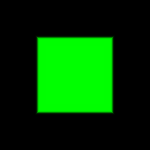

In [11]:
image_PIL = transform2(image)
image_PIL.show()

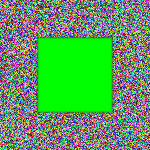

In [12]:
random = torch.rand((3,150,150))
tot = mask*image + (1-mask)*random
image_PIL = transform2(tot)
image_PIL.show()

In [29]:
class Fractal_Patch_Generator_Ghost(nn.Module):

    def __init__(self, dim_patch, dim_image, max_dim, tile_class, angle_type):
        super(Fractal_Patch_Generator_Ghost, self).__init__()
        #Dimension of the patch, smallest component of the attack
        self.dim_patch = dim_patch 
        #Dimension of the image we want to create
        self.dim_image = dim_image
        #Max dimension for the patch
        self.max_dim = max_dim
        #Tile function
        self.tile_class = tile_class
        #Angle Type
        self.angle_type = angle_type

        #Check if they are compatible
        if self.dim_image % self.dim_patch != 0:
            raise Exception('Patch and Image do not have compatible dimensions. Please select the image as a multiple of patch.')

        # How many lines in the grid?
        self.dim_grid = int(self.dim_image/self.dim_patch)
    
    def populate(self, params):
        self.patches = []
        self.masks = []

        for i in range(1,self.max_dim+1):
            patch, mask = self.tile_class(self.dim_patch*i, params)
            print(mask.shape)
            self.patches.append(patch)
            self.masks.append(mask)
            
    
    def application(self):
        #Creation of the complete image
        self.image = torch.rand((3,self.dim_image,self.dim_image))
        #Creation of the complete mask
        self.complete_mask = torch.zeros((3,self.dim_image,self.dim_image))
        #Creation of the bool vector 
        self.bool_matrix = np.ones((self.dim_grid,self.dim_grid), dtype=int)
        #Creation of the index vector
        self.index_vector = np.arange(0,(self.dim_grid**2))
        #Creation of the shuffled version
        shuffled_index_vector = np.random.choice(self.index_vector, size=self.dim_grid**2, replace=False)
        # #PIL image of the patch
        # patch_PIL = transform2(patch)

        for index in shuffled_index_vector:
            #Translate the index in coordinates
            i = int(index/self.dim_grid) #row
            j = index%self.dim_grid      #column

            #Check if the corner is still available
            if self.bool_matrix[i][j]:
                av_dim = self.available_dimensions(i,j)
                
                #Choose randomly the dimension
                chosen_dim = int(np.random.choice(av_dim, 1))
                # print(chosen_dim)

                #Change the bool in the bool matrix in False, no longer available
                self.bool_matrix[i:i+chosen_dim,j:j+chosen_dim] = 0

                if self.angle_type == 0:
                    self.image[:,i*self.dim_patch:(i+chosen_dim)*self.dim_patch,j*self.dim_patch:(j+chosen_dim)*self.dim_patch] = self.patches[chosen_dim-1]

                elif self.angle_type == 1:
                    angle = random.choice([0,90,180,270])
                    #Apply the patch to the image
                    self.image[:,i*self.dim_patch:(i+chosen_dim)*self.dim_patch,j*self.dim_patch:(j+chosen_dim)*self.dim_patch] = TF.rotate(self.patches[chosen_dim-1],angle)

                else:
                    #Select the angle
                    angle = random.uniform(0,360)
                    #Rotate
                    out = TF.rotate(self.patches[chosen_dim-1], angle)
                    out2 = TF.rotate(self.masks[chosen_dim-1], angle)
                    # color = self.ex_colors[chosen_dim-1]
                    # #Color in the angles
                    # mask = self.masks[chosen_dim-1]
                    # out[mask] = color[mask]
                    # #Apply the patch to the image
                    self.image[:,i*self.dim_patch:(i+chosen_dim)*self.dim_patch,j*self.dim_patch:(j+chosen_dim)*self.dim_patch] = out
                    self.complete_mask[:,i*self.dim_patch:(i+chosen_dim)*self.dim_patch,j*self.dim_patch:(j+chosen_dim)*self.dim_patch] = out2

        return self.image, self.complete_mask
        
    def available_dimensions(self,i,j):
        #It is always possible to put the smallest version of the patch
        av_dim = [1]

        for dim in range(2, self.max_dim+1):
            sub_matrix = self.bool_matrix[i:i+dim,j:j+dim]
            if np.sum(sub_matrix) == dim**2:
                av_dim.append(dim)
            else:
                break
        
        return av_dim

In [30]:
tile_function = Tile_Creator_Square()
dim_tile = 16
dim_patch = 640 
mul_fact = 4
params = tile_function.Params_Creator()
gen_function = Fractal_Patch_Generator_Ghost(dim_tile, dim_patch, mul_fact, tile_function,2)

In [31]:
gen_function.populate(params)

torch.Size([3, 16, 16])
torch.Size([3, 32, 32])
torch.Size([3, 48, 48])
torch.Size([3, 64, 64])


In [32]:
image, mask = gen_function.application()

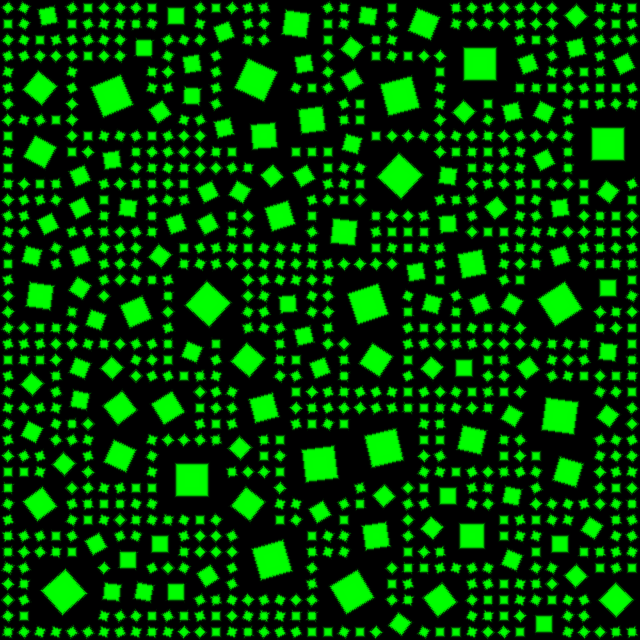

In [33]:
image_PIL = transform2(image)
image_PIL.show()

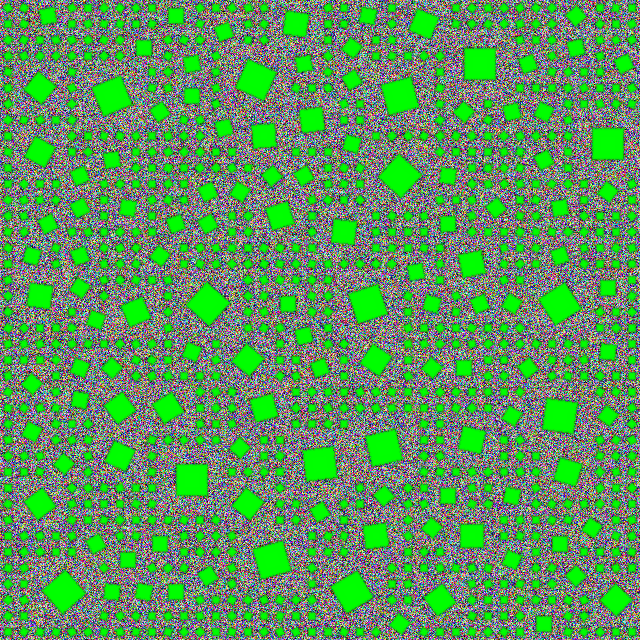

In [34]:
random = torch.rand((3,640,640))
tot = mask*image + (1-mask)*random
image_PIL = transform2(tot)
image_PIL.show()